# Titanic Dataset - Classification model showcase 
In this short project, we are going to look at the now classic *Titanic* dataset, which contains data about 1309 passengers of the cruise ship *Titanic* which sunk in the year 1912 after crashing into
an iceberg, leaving around 1450 dead. The dataset contains informations about the passengers' name, sex, age, survival status, the ticket class, ticket description, as well as number of siblings/sposues, 
parents/children onboard, place of boarding and price of their fare. Our motivation is to find out which of these predictiors are important in determining whether an individual survived the 
catastrophe or not and subsequently build a predictive model that will be able to determine the outcome based on these predictors on a before-unseen test set. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
# Import the dataset from a .csv file 
df = pd.read_csv('titanic.csv') 
df = df.drop(columns = ['Destination', 'Lifeboat', 'Body', 'Class', 'WikiId', 'Age_wiki', 'Name_wiki', 'Hometown', 'Boarded'])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Variables 
The dataset contains (excluding the ID variable) 6 categorical variables and 4 numerical variables, some of which we won't use at all or discretize for some models that may perfrom better after 
some feature engineering. The output variable is the binary variable 'Survived', indicating whether the individual survived the tragedy (=1) or not (=0). 

## Data Quality 
Let's look at how many observations of each predictor are missing from our dataset.

In [4]:
df.isna().sum(axis = 0)

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Unfortunately, we have to exclude all the observations where our output variable is missing, since we can neither use there observations for dfing, nor for evaluating the 
performance of our models. 

In [5]:
# Delete NaN values in the output variable 
df = df.dropna(subset = ['Survived'])

# Exploratory Data Analysis 
Let's look at some exploratory analysis which might give us some insight about which of the predictors might be useful at indicating whether the person in question survived or not. Firstly, let's print the descirptive statistics for our numerical and categorical variables. While variables Parch and SibSp are numerical (indicating a number of family members onboard), we'll consider them as categorical during this phase, since the absolute counts will be more informative than calculating e.g. standard deviation or mean. The descriptive stats for our 'actual' numerical variables look as follows:

In [6]:
num_vars = ['Age', 'Fare']
cat_vars = ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch']
df[['Age', 'Fare',]].describe()

,Age,Fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200


And the counts for categorical variables (as well as the outcome variable):

In [223]:
for c in cat_vars: 
    print("---- {} ---".format(c))
    print(df[c].value_counts())

---- Survived ---
0.0    549
1.0    342
Name: Survived, dtype: int64
---- Pclass ---
3    491
1    216
2    184
Name: Pclass, dtype: int64
---- Sex ---
male      577
female    314
Name: Sex, dtype: int64
---- SibSp ---
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
---- Parch ---
0    678
1    118
2     80
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64


We may visualize some of these counts in pie graphs:

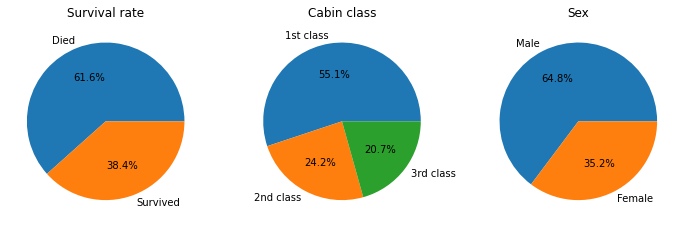

In [7]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))
ax[0].pie(df.Survived.value_counts(), labels = ['Died', 'Survived'], autopct='%1.1f%%')
ax[0].title.set_text('Survival rate')
ax[1].pie(df.Pclass.value_counts(), labels = ['1st class', '2nd class', '3rd class'], autopct='%1.1f%%')
ax[1].title.set_text('Cabin class')
ax[2].pie(df.Sex.value_counts(), labels = ['Male', 'Female'], autopct='%1.1f%%')
ax[2].title.set_text('Sex')

Another interesting thing to explore would be the survival rate based on our predictors. These graphs will allow us to see whether there's a visual implication that our input variable will be significant in determining the survival of a given passenger. In this step we will also create a new variable, *Age_disc*, which will discretize (bin) the continuous numerical variable *Age*. We will also group the less populous categories in the variables *SibSp* and *Parch* for easier visualization (and maybe prediction).

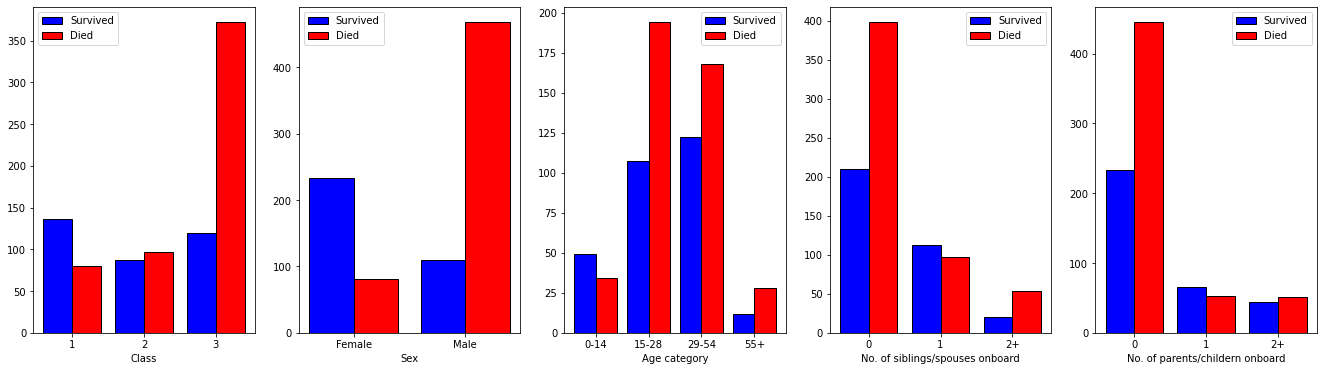

In [8]:
fig, ax = plt.subplots(1, 5, figsize = (23, 6))
width = .4
ax[0].bar(np.arange(3) - 0.2, df.groupby('Pclass').sum()['Survived'], width, color = 'b', edgecolor = 'k')
ax[0].bar(np.arange(3) + 0.2, df.groupby('Pclass').count()['Survived'] - df.groupby('Pclass').sum()['Survived'] , width, color = 'r', edgecolor = 'k')
ax[0].set_xticks(np.arange(3))
ax[0].set_xticklabels([1, 2, 3])
ax[0].set_xlabel('Class')
ax[0].legend(['Survived', 'Died'], loc = 'best')

ax[1].bar(np.arange(2) - 0.2, df.groupby('Sex').sum()['Survived'], width, color = 'b', edgecolor = 'k')
ax[1].bar(np.arange(2) + 0.2, df.groupby('Sex').count()['Survived'] - df.groupby('Sex').sum()['Survived'] , width, color = 'r', edgecolor = 'k')
ax[1].set_xticks(np.arange(2))
ax[1].set_xticklabels(['Female', 'Male'])
ax[1].set_xlabel('Sex')
ax[1].legend(['Survived', 'Died'], loc = 'best')

# Discretize Age - instead of doing the binning by quantiles, we will choose a more loose approach in which we'll try to capture age groups that feel more natural for human age.
df['Age_disc'] = pd.cut(x = df['Age'], bins = [0, 15, 29, 55, 100])

ax[2].bar(np.arange(4) - 0.2, df.groupby('Age_disc').sum()['Survived'], width, color = 'b', edgecolor = 'k')
ax[2].bar(np.arange(4) + 0.2, df.groupby('Age_disc').count()['Survived'] - df.groupby('Age_disc').sum()['Survived'] , width, color = 'r', edgecolor = 'k')
ax[2].set_xticks(np.arange(4))
ax[2].set_xticklabels(['0-14', '15-28', '29-54', '55+'])
ax[2].set_xlabel('Age category')
ax[2].legend(['Survived', 'Died'], loc = 'best')

df['Sib_disc'] = pd.cut(x = df['SibSp'], bins = [0, 1, 2, 10], right = False)

ax[3].bar(np.arange(3) - 0.2, df.groupby('Sib_disc').sum()['Survived'], width, color = 'b', edgecolor = 'k')
ax[3].bar(np.arange(3) + 0.2, df.groupby('Sib_disc').count()['Survived'] - df.groupby('Sib_disc').sum()['Survived'] , width, color = 'r', edgecolor = 'k')
ax[3].set_xticks(np.arange(3))
ax[3].set_xticklabels(['0', '1', '2+'])
ax[3].set_xlabel('No. of siblings/spouses onboard')
ax[3].legend(['Survived', 'Died'], loc = 'best')

df['Par_disc'] = pd.cut(x = df['Parch'], bins = [0, 1, 2, 10], right = False)

ax[4].bar(np.arange(3) - 0.2, df.groupby('Par_disc').sum()['Survived'], width, color = 'b', edgecolor = 'k')
ax[4].bar(np.arange(3) + 0.2, df.groupby('Par_disc').count()['Survived'] - df.groupby('Par_disc').sum()['Survived'] , width, color = 'r', edgecolor = 'k')
ax[4].set_xticks(np.arange(3))
ax[4].set_xticklabels(['0', '1', '2+'])
ax[4].set_xlabel('No. of parents/childern onboard')
ax[4].legend(['Survived', 'Died'], loc = 'best')

These graphs give us some valuable insight. For example, it seems like the emergency motto 'women and children first' was honored during the Titanic disaster, as the survival rate of women and children aged 0-14 was way higher than in the remaining categories. The variable *Pclass* also seems to be correlated with chances of survival, which can be probably explained by better location and abundance of lifeboats near cabins of people who bought 1st/2nd class tickets. The other two variables also show some predictive potential, but the explanation is not so straightforward anymore.

# Imputation
Our dataset currently looks as follows:

In [9]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_disc,Sib_disc,Par_disc
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(15, 29]","[1, 2)","[0, 1)"
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(29, 55]","[1, 2)","[0, 1)"
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"(15, 29]","[0, 1)","[0, 1)"
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"(29, 55]","[1, 2)","[0, 1)"
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,"(29, 55]","[0, 1)","[0, 1)"


Before starting our work on the actual machine learning model, there's still plenty of things to take care of. Firstly, there are still some columns with NaN values, which have to be dealt with. Either we can ignore these observations completely, but this can lead to a loss of valuable information if there's a lot of rows with missing values. The other strategy is to impute these values with the mean/median value, maybe add some noise, or use some more sophisticated methods such as linear regression on the remaining columns. 
We are missing values in the *Cabin*, *Age* and *Embarked* variables, and there's quite a lot of them (687, 177 and 2 respectively). Let's create a new category 'U' (for *unknown*) instead of the NaN *Cabin* values, impute the missing *Age* values with the mean *Age* value with some added noise and replace the NaN *Embarked* values with the mode. We're assuming that these values are missing at random, otherwise the imputation would skew our data. 

In [10]:
# Impute the missing Cabin values as 'Unknown'
df.loc[df['Cabin'].isna(), 'Cabin'] = 'U'

In [11]:
# Impute the missing Age values with the Age mean and noise: a random value of normal distribution with mean 0 and standard deviation same as our Age variable
df.loc[df['Age'].isna(), 'Age'] = df['Age'].mean() + np.random.normal(1, np.std(df['Age']))
df['Age_disc'] = pd.cut(x = df['Age'], bins = [0, 15, 29, 55, 100]) # Discretize the values we just imputed

In [17]:
# Delete observations that have missing Embarked values
df.loc[df['Embarked'].isna(), 'Embarked'] = df['Embarked'].value_counts().idxmax()

# Feature engineering
Now that all missing values have been taken care of, we may try to squeeze some more information out of the data and make it more useable for our ML model. We actually already did this: The discretization of numerical predictiors is also a kind of feature engineering. But now let's try something more advanced, with a bit of text mining. The *Cabin* variable has elements that look something like this:

In [18]:
df.loc[df['Cabin'] != 'U', 'Cabin'][:10]

1             C85
3            C123
6             E46
10             G6
11           C103
21            D56
23             A6
27    C23 C25 C27
31            B78
52            D33
Name: Cabin, dtype: object

Since there are a lot of unique values, let's take just the cabin area (indicated by the capital letter). This will give us a cleaner variable with a bit more digestable information and it will hopefully 
also provide some insight into the data, since the cabin areas will likely have similar levels of 'survivability'. Maybe we will create a new variable that is a proxy to the *Pclass* variable, but let's not get ahead of ourselves:

In [19]:
# Feature engineering the Cabin variable
import re

# Create a mask, TRUE when element contains a number => these are the observations we want to strip of them
mask  = df['Cabin'].str.contains('\\d', regex = True)

# For cycle that takes the first letter from Cabin values that contain numbers
for i, num in enumerate(mask):
    if num:  df.loc[i, 'Cabin'] = df.loc[i, 'Cabin'][0]

Let's visually inspect the significance of cabin area on passenger survival:

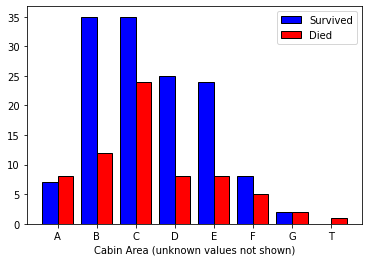

In [20]:
plt.bar(np.arange(8) - 0.2, df.loc[df['Cabin'] != 'U'].groupby('Cabin').sum()['Survived'], width, color = 'b', edgecolor = 'k')
plt.bar(np.arange(8) + 0.2, df.loc[df['Cabin'] != 'U'].groupby('Cabin').count()['Survived'] - df.loc[df['Cabin'] != 'U'].groupby('Cabin').sum()['Survived'], width, color = 'r', edgecolor = 'k')
plt.xticks(np.arange(8), ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
plt.xlabel('Cabin Area (unknown values not shown)')
plt.legend(['Survived', 'Died'], loc = 'best')
plt.show()

It seems that the passengers whose *Cabin* value wasn't missing had higher chances of survival. Is this just a proxy for 1st Class? 

In [23]:
df[['Pclass', 'Cabin']].value_counts()

Pclass  Cabin
3       U        479
2       U        168
1       C         59
        B         47
        U         40
        D         29
        E         25
        A         15
2       F          8
3       F          5
2       D          4
        E          4
3       G          4
        E          3
1       T          1
dtype: int64

Kind of, since most passengers in the 1st class weren't missing the *Cabin* value. However, the F cabin area had only 2nd/3rd class passengers in it and it's showing higher chances of survival, so it is possible we got some more info out of our dataset (or it might mean that those who survived were more likely to give the information about their cabin, but it's still relevant for our prediction).
There's still some feature engineering to do - such as one-hot encoding our categorical variables and scaling the numerical ones (since some models rely on these preprocessing steps). However, we will do these steps during the model building, since Python allows us to use the 'Pipeline' Class to include these steps right before the model building. 

# Building a classification model
Now that our data is clean and we're done with the feature engineering, we can move on to building the classification model. Since this is a showcase example, we'll look at several ML models that we can use and compare their performance on our dataset. The models that we will train are classic logistic regression, support vector machine, decision tree, random forest and gradient boosting machine. 
Each of these machine learning models works differently with various pros and cons, but we won't focus on the math specifics. For now, these models are capable of detecting patterns and predicting the output variable (whether a passenger died/survived) on 'new' observations, with 'new' meaning that the algorithm has not seen this particular observation yet. 

## Logistic Regression 
Firstly, let's choose our design matrix X (the matrix of our chosen predictors) and denote the output variable vector as y. We will omit the variables *Name* and *Ticket*, since they don't seem to carry valuable information about the survival of the passenger; we should also omit the variables *Age*, *SibSp* and *Parch* since we will be using their discretized counterparts created during the feature engineering phase. 

In [24]:
# Create the design matrix and the output vector
y = df['Survived']
X = df[['Pclass', 'Sex', 'Fare', 'Cabin', 'Embarked', 'Age_disc', 'Sib_disc', 'Par_disc']]
# Let's also update our variable lists: 
num_vars = ['Fare']
cat_vars = ['Pclass', 'Sex', 'Cabin', 'Embarked', 'Age_disc', 'Sib_disc', 'Par_disc']

In [25]:
# Load modules required
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder 

# Preparing for Column Transformer 
num_trans = StandardScaler()
cat_trans = OneHotEncoder(handle_unknown = 'ignore')

# Splitting the dataset to training (85%) & testing sets (15%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 10)

In [26]:
# Create a transformer/preprocessor for the variables 
preprocessor = ColumnTransformer([
    ('num', num_trans, num_vars),
    ('cat', cat_trans, cat_vars)
])

# Create the pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

We created a pipeline, which will allow us to preprocess our data in the intended way just before fitting a logistic regression model. Since we'll fit model on the train data, we'll avoid any data leakage, as the same preprocessing steps and scaling are going to be used when evaluating the model quality on the test set. Now let's train the data on our training set: 

In [28]:
# Fitting the model 
pipe.fit(X_train, y_train)

# Evaluate the model performance on the training set (using 5-fold CV) and the test set:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe, X_train, y_train, cv = 5)
print('The mean CV accuracy on the training test is {:.2f}%.'.format(scores.mean() * 100))
print('The model accuracy on the test set is {:.2f}%.'.format(pipe.score(X_test, y_test) * 100))

The mean CV accuracy on the training test is 79.78%.
The model accuracy on the test set is 82.09%.


As we can see, we achieved about 80% accuracy on the test set (accuracy meaning the fraction of correct predictions), and it seems that our model didn't overfit. However, since our dataset was a bit imbalanced (~60% dead and ~40% survivors), accuracy may not be the best metric to base our model performance on. We may try some more robust metrics, such as the *f-score*, which takes precision and recall into account and gives us a better picture of the model performance:

In [30]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
preds = pipe.predict(X_test)
print('f1 score of logistic regression is {:.3f}.'.format(f1_score(preds, y_test)))
print(classification_report(preds, y_test, target_names = ['Died', 'Survived']))

f1 score of logistic regression is 0.769.
              precision    recall  f1-score   support

        Died       0.85      0.85      0.85        82
    Survived       0.77      0.77      0.77        52

    accuracy                           0.82       134
   macro avg       0.81      0.81      0.81       134
weighted avg       0.82      0.82      0.82       134



The use of this metric would be more important if our dataset was more imbalanced (e.g. 90% dead and 10% survivors). Let's try another model, a support vector machine 
## Kernelized support vector machine 
The code will be pretty much the same like with logistic regression, but there's one more thing to do here - parameter optimalization. SVMs have a *regularization parameter* C and a *kernel coefficient* gamma, which we have to tune to improve the performance of our model. However, we cannot tune the paramaters by repeatedly fitting the model on our training set, hence we need to split it into training and validation sets. Luckily, we can use the function GridSearchCV to do this for us while again avoiding any data leakage, using CV scoring to select the best regularization parameter. 

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# Select a parameter grid for the parameters we want to tune
param_grid = {'classifier__C' : [0.01, 0.1, 1, 10, 100],
             'classifier__gamma': [0.01, 0.1, 1, 10]}

# Create our pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

# Use GridSearchCV to fit the models repeatedly and find the best C, as well as calculate the CV scores
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 6)
grid.fit(X_train, y_train)
preds = grid.predict(X_test)

# Look at the best model
print('Best estimator: {}.'.format(grid.best_estimator_))
print('The best mean accuracy on the training set is {:.2f}%.'.format(grid.best_score_ * 100))
print('Test. acc. je {:.2f}%.'.format(grid.score(X_test, y_test) * 100))
print('f1 score of SVM is {:.3f}.'.format(f1_score(preds, y_test)))

Best estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Fare']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Pclass', 'Sex', 'Cabin',
                                                   'Embarked', 'Age_disc',
                                                   'Sib_disc', 'Par_disc'])])),
                ('classifier', SVC(C=100, gamma=0.01))]).
The best mean accuracy on the training set is 81.77%.
Test. acc. je 82.84%.
f1 score of SVM is 0.777.


As we can see, after tuning the parameters we were able to achieve a better accuracy on the test set and the f1_score improved by a bit as well, meaning the performance of our kernelized support vector machine was better than logistic regression. 
## Decision Tree
A decision tree is a simple classification method based on binary questions about the data to determine the prediction class. The classification is simple to understand even for laymen, but we shouldn't expect a great performance with more complex datasets because of how simple the algorithm is. 
Decision trees (as well as random forests and gradient boosting machines that are based on them) work really well with unprocessed data. This shows us the benefit of using pipelines to build our models - since we modified the dataset just before fitting the model, we have our design matrix saved in the original form and therefore ready to use with our decision trees. We should also tweak our training dataset a bit, taking the original *Age*, *SibSp* and *Parch* variables, as discretizing and one-hot-encoding imposes sparsity on our dataset, which may harm the performance of our decision trees and consequent ensemble models (ensemble models meaning models made up of combining decision trees in various ways). We will use *pre-pruning* (setting the maximal depth of our tree to 4 branches before modelling) to avoid overfitting and for a clearer visualization of how a decision tree makes the classification:

In [87]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.impute import SimpleImputer

# Modify the design matrix to use undiscretized numerical variables
X = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'Cabin', 'Fare']]
num_vars = ['Age', 'SibSp', 'Parch', 'Fare']
cat_vars = ['Pclass', 'Sex', 'Embarked', 'Cabin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 10)

# Update the preprocessor not to transform numerical variables 
preprocessor = ColumnTransformer([
    ('cat', cat_trans, cat_vars),
], remainder = 'passthrough')

# Create the pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth = 5))
])

# Fit the DT
pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)

print('Train accuracy is {:.2f}%.'.format(pipe.score(X_train, y_train) * 100))
print('Test set accuracy is {:.2f}%.'.format(pipe.score(X_test, y_test) * 100))
print('f1-score of the decision tre is {:.3f}.'.format(f1_score(preds, y_test)))


Train accuracy is 84.94%.
Test set accuracy is 84.33%.
f1-score of the decision tre is 0.807.


Let's visualize the 'flowchart' of our decision tree:

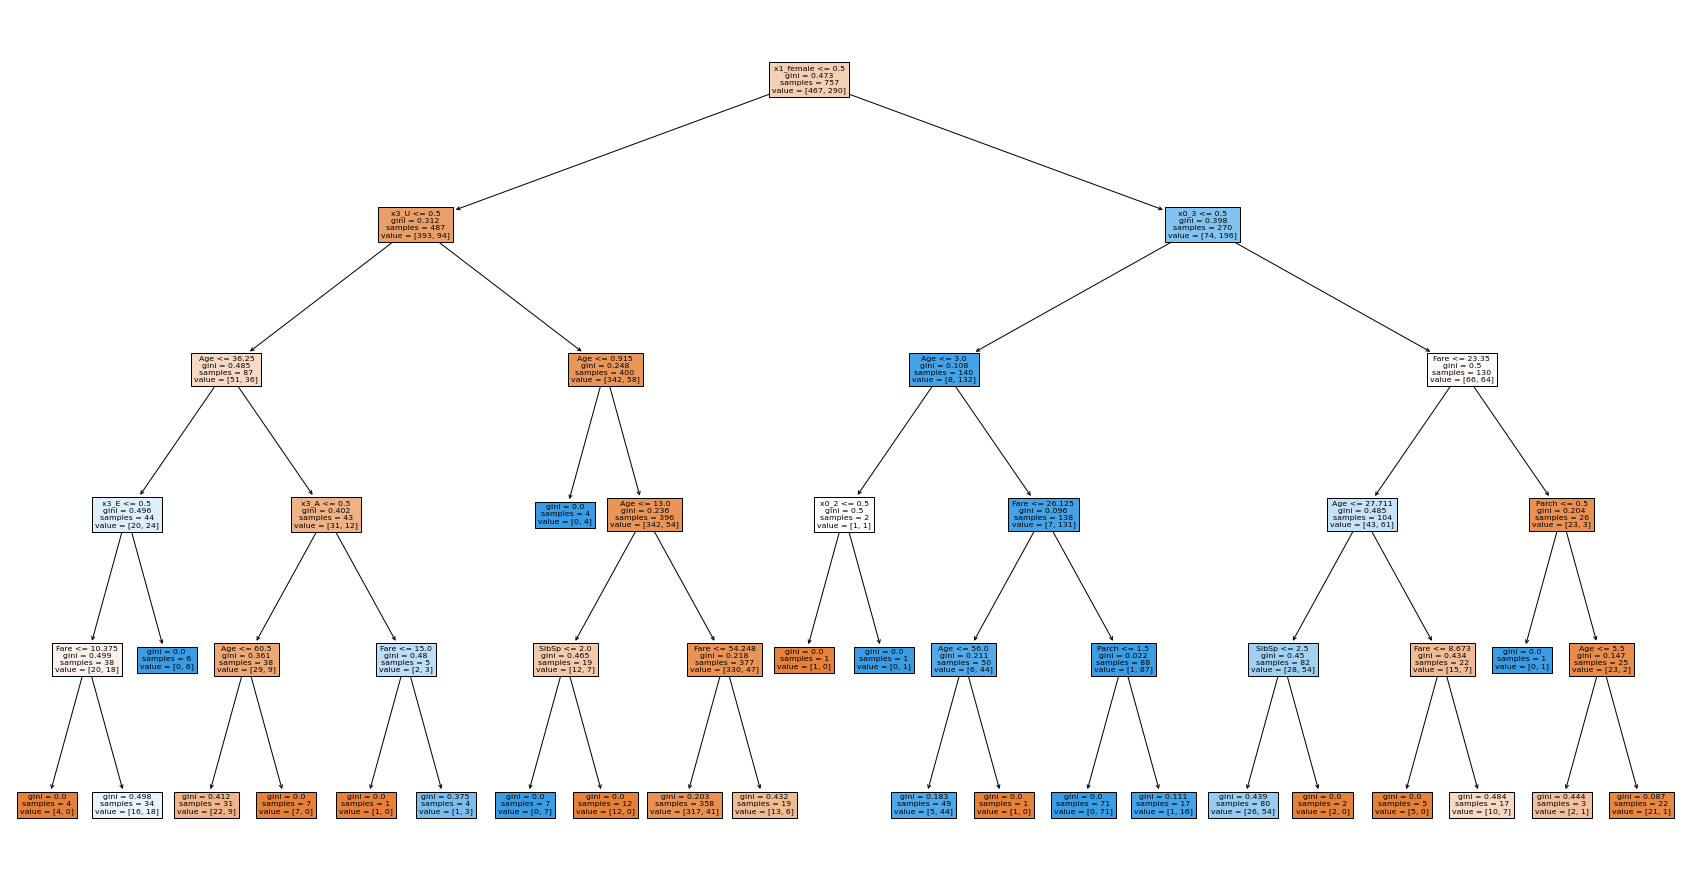

In [88]:
plt.figure(figsize = (30, 16))
var_names = np.append(pipe.named_steps['preprocessor'].transformers_[0][1].get_feature_names(), num_vars)
plt.show(plot_tree(pipe['classifier'], filled = True, feature_names = var_names))

We see that our 4-node deep decision tree worked fairly well and was capable of achieving even better performance than logistic regression or KSVM - this might be due to the simplicity of our dataset. We can also look up *feature importances* of the model, a metric that shows us which of the predictors were considered important by our decision tree:

<BarContainer object of 21 artists>

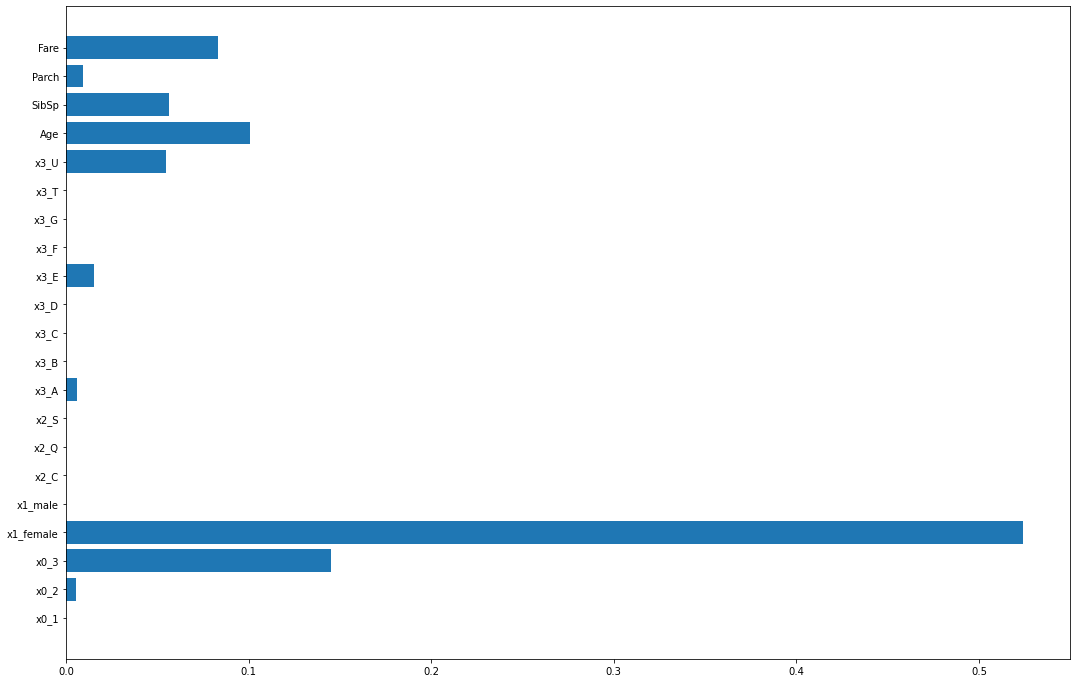

In [89]:
feats = pipe['classifier'].feature_importances_
plt.figure(figsize = (18, 12))
plt.barh(var_names, feats)

We could comment on and improve our decision tree (e.g. by choosing the max. tree depth by a grid search), but let's move on to a more useful and powerful algorithm. 
## Random Forest
Random forests are powerful algorithms that use a lot of trees build on specific part of the dataset to predict the outcomes. The use of (even 100s) of trees has also the effect of regularization which helps us avoid overfitting the model and making it more generalizable. Let's build a random forest on our dataset. It also has some parameters which we have to set before training the model and therefore optimize by using GridSearchCV. 

In [111]:
from sklearn.ensemble import RandomForestClassifier

# Parameter grid
param_grid = {'classifier__n_estimators' : [10, 30, 50, 100, 200, 500],
             'classifier__max_depth' : [2, 4, 6, 8, 10, 20]}

# Create the pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state = 42))
])

grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5)
grid.fit(X_train, y_train)
preds = grid.predict(X_test)

print('Best parameters: {}.'.format(grid.best_params_))
print('Naj CV acc. je {:.2f}%.'.format(grid.best_score_ * 100))
print('Test. acc. je {:.2f}%.'.format(grid.score(X_test, y_test) * 100))
print('f1-score of random forest is {:.3f}.'.format(f1_score(y_test, preds)))

Best parameters: {'classifier__max_depth': 6, 'classifier__n_estimators': 30}.
Naj CV acc. je 82.16%.
Test. acc. je 86.57%.
f1-score of random forest is 0.804.


It looks like the random forest performed pretty well on the test data, despite the use of some one-hot-encoded categorical variables, which is not ideal for this classifier. We see that the train accuracy is a bit lower yet the model generalizes well - this could be caused by the small size of the dataset and the more 'predictable' observations could have ended up in the test dataset after splitting. We can look at the feature importances, as an indication which of the predictors does our random forest deem important. 

<BarContainer object of 21 artists>

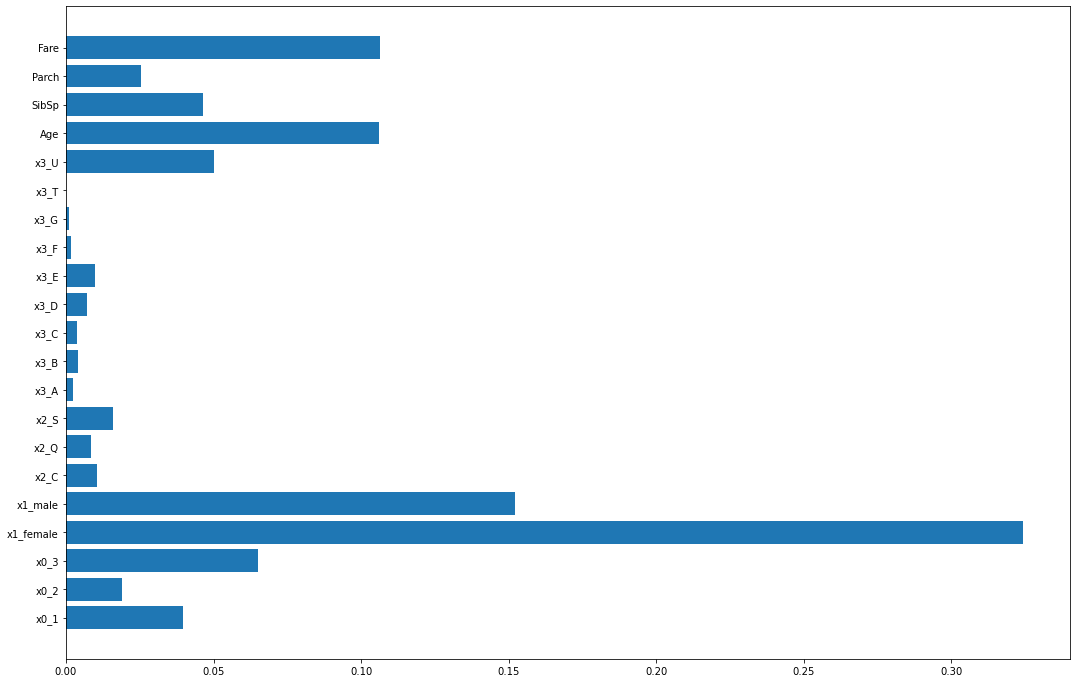

In [112]:
plt.figure(figsize = (18, 12))
plt.barh(var_names, grid.best_estimator_['classifier'].feature_importances_)

We can see that the random forest considers *Sex* and *Age* as very important predictors, which was expected. What may be a little bit surprising is the *Fare* is important as well and *Pclass* not so much. This could indicate that *Fare* is a proxy to cabin class (a significant negative correlation can be shown with a kendall tau coefficient). Some significance was also put on unknown *Cabin* variable and varaibles *Parch*, *SibSp*. Let's try another way and use a gradient boosting machine, which has an experimental implementation in the scikit-learn library and a workaround so we do not have to one-hot encode our cat_vars. 

## Gradient Boosting Machine 
Another algorithm based on 'stacking' decision trees are gradient boosting machines, which tend to outperform random forests. Let's build one for our Titanic dataset. We also have to play around with our variables a bit to make them more digestible for the *HistGradientBoostingClassifier*, which is also capable of working with categorical variables, so no need to create dummies!

In [113]:
# Cycle to categorize cat.vars to numbers, as HGBC only takes categorical variables written as floats
pd.options.mode.chained_assignment = None  # default='warn'
for i in ['Sex', 'Embarked', 'Cabin']:
    X[i] = X[i].astype('category')
    X[i + '_num'] = X[i].cat.codes
    X = X.drop(columns = i)

# Create new splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 10)

In [114]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

param_grid = {'max_depth' : [5, 10, 20, 30, 50], 
             'max_iter' : [50, 100, 200, 300], 
             'learning_rate' : [0.001, 0.01, 0.1]}

grid = GridSearchCV(HistGradientBoostingClassifier(categorical_features = [0, 2, 3, 5, 6, 7], random_state = 42), param_grid = param_grid, cv = 5)
grid.fit(X_train, y_train)
preds = grid.predict(X_test)

print('Best parameters: {}.'.format(grid.best_params_))
print('Naj CV acc. je {:.2f}%.'.format(grid.best_score_ * 100))
print('Test. acc. je {:.2f}%.'.format(grid.score(X_test, y_test) * 100))
print('f1-score of GBM is {:.3f}.'.format(f1_score(y_test, preds)))

Best parameters: {'learning_rate': 0.01, 'max_depth': 20, 'max_iter': 300}.
Naj CV acc. je 81.64%.
Test. acc. je 85.82%.
f1-score of GBM is 0.816.


We see that we got a similar result as with the random forest in terms of accuracy. We have to keep in mind that we're dealing with a small dataset (not even 900 observations), so even the simple algorithms such as decision trees or logistic regression without regularization may perform similarly well to more complex algorithms such as KSVM, random forests or GBM. We were able to build models with 80-86% accuracy on the test set, which isn't great, but still ok for such a simple dataset.

This notebook was a showcase of how to explore the basics of data exploration, cleaning, feature engineering and how implement various ML algorithms in the great scikit-learn library and tune their parameters via a grid search cross-validation. 